In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from itertools import izip
import tensorflow as tf
from tf_vgg.kaggle_data import *
from tf_vgg import vgg16_bw, utils, vgg16
import matplotlib.pyplot as plt



In [2]:
lungs = get_training_lungs()
labels = get_training_lung_labels()

In [3]:
for tup,label in izip(lungs, labels):
    print tup[0].shape
    print tup[1]
    print label
    break
    

(60, 224, 224)
059d8c14b2256a2ba4e38ac511700203
1


### TEST VGG-BW

In [5]:
VGG_DIR = "/notebooks/sharedfolder/lungcancerdl/tf_vgg/"
VGG16_WEIGHT = VGG_DIR+"vgg16.npy"
nn_weights = np.load(VGG16_WEIGHT, encoding='latin1').item()

In [6]:
for k in nn_weights:
    print k, nn_weights[k][0].shape, nn_weights[k][1].shape

conv5_1 (3, 3, 512, 512) (512,)
fc6 (25088, 4096) (4096,)
conv5_3 (3, 3, 512, 512) (512,)
fc7 (4096, 4096) (4096,)
fc8 (4096, 1000) (1000,)
conv5_2 (3, 3, 512, 512) (512,)
conv4_1 (3, 3, 256, 512) (512,)
conv4_2 (3, 3, 512, 512) (512,)
conv4_3 (3, 3, 512, 512) (512,)
conv3_3 (3, 3, 256, 256) (256,)
conv3_2 (3, 3, 256, 256) (256,)
conv3_1 (3, 3, 128, 256) (256,)
conv1_1 (3, 3, 3, 64) (64,)
conv1_2 (3, 3, 64, 64) (64,)
conv2_2 (3, 3, 128, 128) (128,)
conv2_1 (3, 3, 64, 128) (128,)


### Convert conv1_1 to black and white by summing across channels

In [7]:
w,b = nn_weights['conv1_1']
print w.shape, b.shape

(3, 3, 3, 64) (64,)


Notice that conv1_1's weight tensor is 4d, 
there are 64, 3 by 3 by 3 convolutions....
So lets sum up the color channels

Notice that we do not have to change the bias parameter...

w(x - m) => wx - wm

So we have to subtract weight * mean for each channel to the bias term!

In [8]:
b_mean, g_mean, r_mean = [103.939, 116.779, 123.68]
w_copy = np.array(w, copy=True)
w_copy[:,:, 0, :] *= b_mean
w_copy[:,:, 1, :] *= g_mean
w_copy[:,:, 2, :] *= r_mean
print w_copy.shape
bias_extra = np.sum(w_copy, axis=(0,1,2))
print bias_extra.shape
w = np.sum(w, axis=2, keepdims=True)
b -= bias_extra
print w.shape

(3, 3, 3, 64)
(64,)
(3, 3, 1, 64)


In [9]:
nn_weights['conv1_1'][0] = w
nn_weights['conv1_1'][1] = b


for k in nn_weights:
    print k, nn_weights[k][0].shape, nn_weights[k][1].shape
np.save(VGG_DIR + "vgg16_bw.npy", nn_weights)

conv5_1 (3, 3, 512, 512) (512,)
fc6 (25088, 4096) (4096,)
conv5_3 (3, 3, 512, 512) (512,)
fc7 (4096, 4096) (4096,)
fc8 (4096, 1000) (1000,)
conv5_2 (3, 3, 512, 512) (512,)
conv4_1 (3, 3, 256, 512) (512,)
conv4_2 (3, 3, 512, 512) (512,)
conv4_3 (3, 3, 512, 512) (512,)
conv3_3 (3, 3, 256, 256) (256,)
conv3_2 (3, 3, 256, 256) (256,)
conv3_1 (3, 3, 128, 256) (256,)
conv1_1 (3, 3, 1, 64) (64,)
conv1_2 (3, 3, 64, 64) (64,)
conv2_2 (3, 3, 128, 128) (128,)
conv2_1 (3, 3, 64, 128) (128,)


# Lets test it!!!
Load tiger and puzzle images, convert to bw and see if the thing works...

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


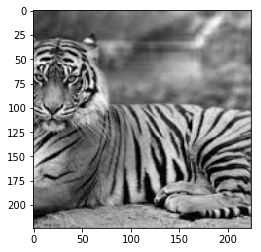

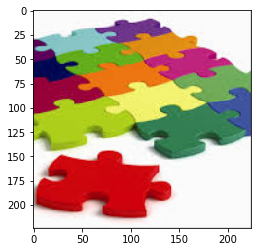

In [10]:
tiger = utils.load_image(VGG_DIR + "test_data/tiger.jpeg")
puzzle = utils.load_image(VGG_DIR + "test_data/puzzle.jpeg")

def show(img):
    if len (img.shape) < 3:
        plt.imshow(img, cmap=plt.cm.gray)
    else:
        plt.imshow(img)#, cmap=plt.cm.gray)
    plt.show()

show(tiger[:,:,1])
show(puzzle)

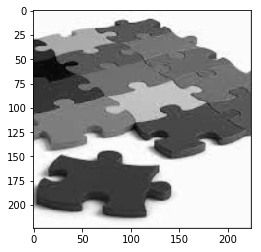

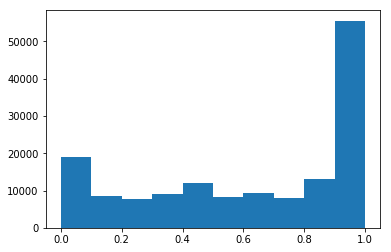

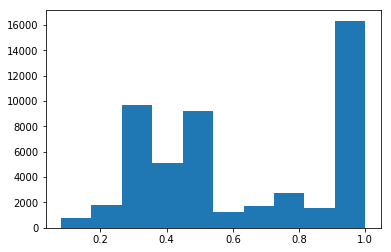

In [11]:
def make_bw(img):
    return np.mean(img, axis=2)
show(make_bw(puzzle))
plt.hist(puzzle.flatten())
plt.show()
plt.hist(make_bw(puzzle).flatten())
plt.show()

In [22]:
puzzle_bw, tiger_bw = make_bw(puzzle), make_bw(tiger)
batch1 = puzzle_bw.reshape((1, 224, 224, 1))
batch2 = tiger_bw.reshape((1, 224, 224, 1))

batch = np.concatenate((batch1, batch2), 0)

with tf.device('/cpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [2, 224, 224, 1])
        feed_dict = {images: batch}

        vgg = vgg16_bw.Vgg16_bw()
        with tf.name_scope("content_vgg"):
            vgg.build(images)

        prob = sess.run(vgg.prob, feed_dict=feed_dict)
        print(prob)
        utils.print_prob(prob[0], VGG_DIR+'/synset.txt')
        utils.print_prob(prob[1], VGG_DIR+'/synset.txt')

/notebooks/sharedfolder/lungcancerdl/tf_vgg/vgg16_bw.npy
npy file loaded
build model started
build model finished: 0s
[[  2.33911254e-04   2.57684872e-03   4.29163716e-04 ...,   1.21784760e-04
    3.31492018e-04   1.49518941e-02]
 [  3.58443765e-04   1.68149406e-03   4.06468753e-04 ...,   7.14312628e-05
    3.59350292e-04   2.08308678e-02]]
('Top1: ', 'n15075141 toilet tissue, toilet paper, bathroom tissue', 0.014951894)
('Top5: ', [('n15075141 toilet tissue, toilet paper, bathroom tissue', 0.014951894), ('n03937543 pill bottle', 0.0098271351), ('n02786058 Band Aid', 0.0089972345), ('n02233338 cockroach, roach', 0.0089873867), ('n03788365 mosquito net', 0.0083531095)])
('Top1: ', 'n03788365 mosquito net', 0.045205146)
('Top5: ', [('n03788365 mosquito net', 0.045205146), ('n15075141 toilet tissue, toilet paper, bathroom tissue', 0.020830868), ('n02786058 Band Aid', 0.012381081), ('n03937543 pill bottle', 0.008632862), ('n02085936 Maltese dog, Maltese terrier, Maltese', 0.0083609847)])


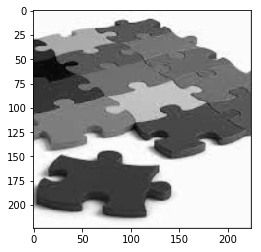

In [12]:
show(batch1.reshape((224,224)))

In [13]:

batch1 = tiger.reshape((1, 224, 224, 3))
batch2 = puzzle.reshape((1, 224, 224, 3))

batch = np.concatenate((batch1, batch2), 0)

# with tf.Session(config=tf.ConfigProto(gpu_options=(tf.GPUOptions(per_process_gpu_memory_fraction=0.7)))) as sess:
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [2, 224, 224, 3])
        feed_dict = {images: batch}

        vgg = vgg16.Vgg16()
        with tf.name_scope("content_vgg"):
            vgg.build(images)

        prob = sess.run(vgg.prob, feed_dict=feed_dict)
        print(prob)
        utils.print_prob(prob[0], VGG_DIR+'/synset.txt')
        utils.print_prob(prob[1], VGG_DIR+'/synset.txt')

/notebooks/sharedfolder/lungcancerdl/tf_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
[[  2.38407316e-09   4.29312852e-09   8.45099546e-10 ...,   7.95111799e-09
    2.29004087e-08   1.97537027e-08]
 [  2.78825620e-08   4.09707042e-07   1.02887325e-08 ...,   1.14151270e-07
    6.34901696e-08   1.54330210e-05]]
('Top1: ', 'n02129604 tiger, Panthera tigris', 0.82691652)
('Top5: ', [('n02129604 tiger, Panthera tigris', 0.82691652), ('n02123159 tiger cat', 0.17136927), ('n02128925 jaguar, panther, Panthera onca, Felis onca', 0.0012765444), ('n02127052 lynx, catamount', 0.00017351808), ('n02128385 leopard, Panthera pardus', 0.00015544184)])
('Top1: ', 'n03598930 jigsaw puzzle', 0.99591452)
('Top5: ', [('n03598930 jigsaw puzzle', 0.99591452), ('n03291819 envelope', 0.00028725105), ('n03908618 pencil box, pencil case', 0.00022548508), ('n03188531 diaper, nappy, napkin', 0.00021818091), ('n04033995 quilt, comforter, comfort, puff', 0.00018459363)])
